In [105]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk',font_scale=1.5,rc={"lines.linewidth": 3})
plt.rcParams['text.usetex'] = True  # write label & legend in LaTex
from dtw import *
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline, interp1d 

In [19]:
### Open data, analyze its structure and modify as wished

# Open the xlsx files
bdata  = pd.read_excel('/Users/imanolarzac/Documents/GitHub/book/Batch Dryer Case Study.xlsx',sheet_name='Trajectories')
cat    = pd.read_excel('/Users/imanolarzac/Documents/GitHub/book/Batch Dryer Case Study.xlsx',sheet_name='classifiers')

# Analyze data visually
print(bdata)        
print(bdata.columns)     # Recorded process variables

# Remove all the columns with missing values. Name the new variable sensor_data_df
sensor_data_df = bdata.dropna()

# Time not given, only index. Assume that sensor measurements were recorded at regular intervals of 1 min; then convert units to hours
sensor_data_df = sensor_data_df.copy()     # Create a copy of the DataFrame to avoid SettingWithCopyWarning
sensor_data_df['Time [h]'] = np.zeros(len(sensor_data_df))

for j in sensor_data_df['Batch number'].unique():
    temporary_df = sensor_data_df.loc[sensor_data_df['Batch number'] == j].reset_index(drop=True)
    sensor_data_df.loc[sensor_data_df['Batch number'] == j,'Time [h]'] = temporary_df.index / 60

     Batch number          Phase  Tank level  Differential pressure  \
0         Batch 1  Deagglomerate       0.000                  0.648   
1         Batch 1  Deagglomerate       0.156                  1.028   
2         Batch 1  Deagglomerate       0.981                  1.218   
3         Batch 1  Deagglomerate       1.856                  1.262   
4         Batch 1  Deagglomerate       2.730                  1.332   
...           ...            ...         ...                    ...   
9264     Batch 71       Cooldown      56.971                 -0.857   
9265     Batch 71       Cooldown      56.971                 -0.880   
9266     Batch 71       Cooldown      56.971                 -0.904   
9267     Batch 71       Cooldown      56.971                 -0.917   
9268     Batch 71       Cooldown      56.971                 -0.918   

      Dryer pressure  Power                  Torque                 \
0            119.943                127.302                  8.010   
1      

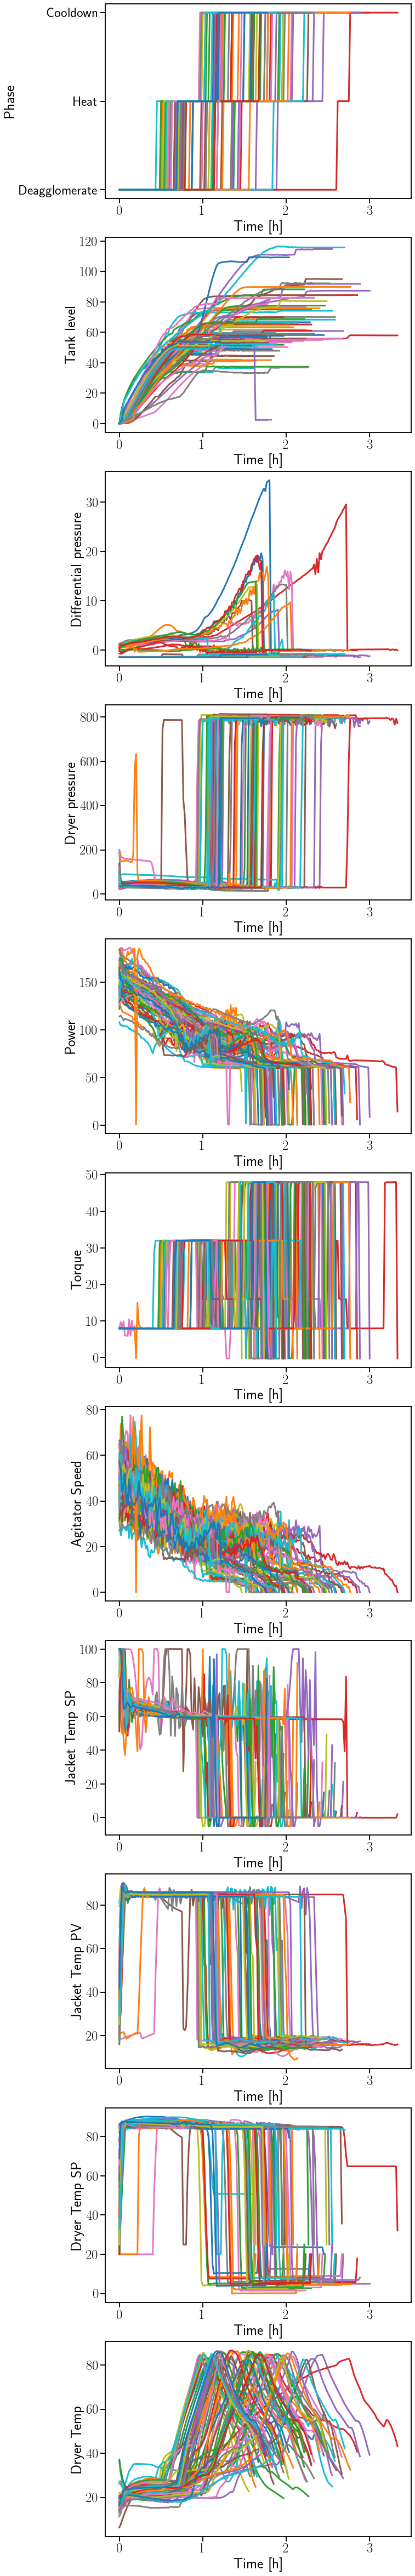

In [23]:
### Plot the unaligned process variable trajectories

variables = sensor_data_df.columns[1:-2]    # Plot every variable except the batch number and the batch time

def PlotUnalignedTrajectories():
    fig, ax = plt.subplots(len(variables),1,figsize=(10,85))
    for j in range(len(variables)):
        variable = variables[j]
        ax[j].set_ylabel(variable)
        ax[j].set_xlabel('Time [h]')
        #ax[j].legend(str(sensor_data_df['Batch number'].unique()))
        for i in sensor_data_df['Batch number'].unique(): 
            ax[j].plot(sensor_data_df.loc[(sensor_data_df['Batch number'] == i),'Time [h]'],sensor_data_df.loc[(sensor_data_df['Batch number'] == i),variable])

PlotUnalignedTrajectories()

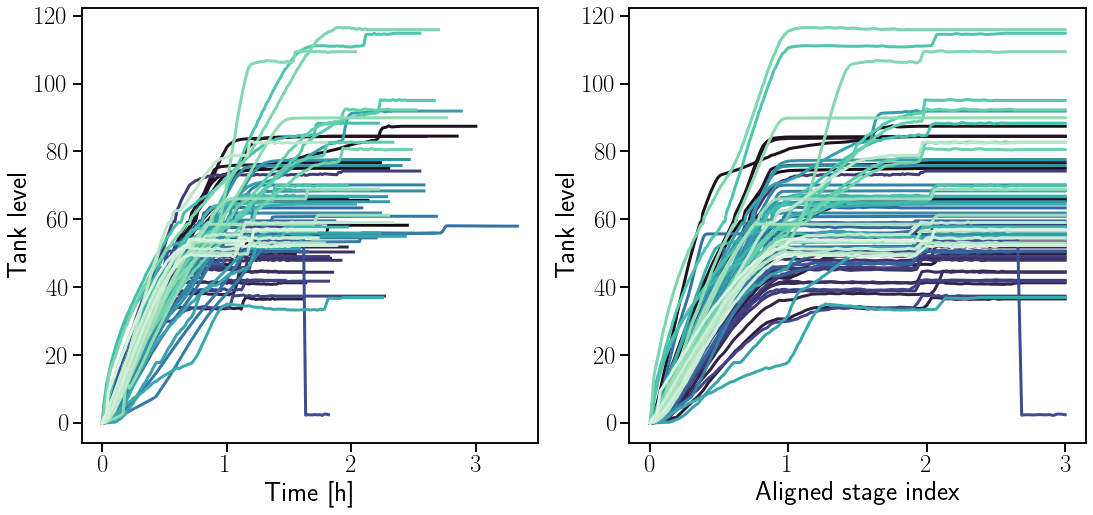

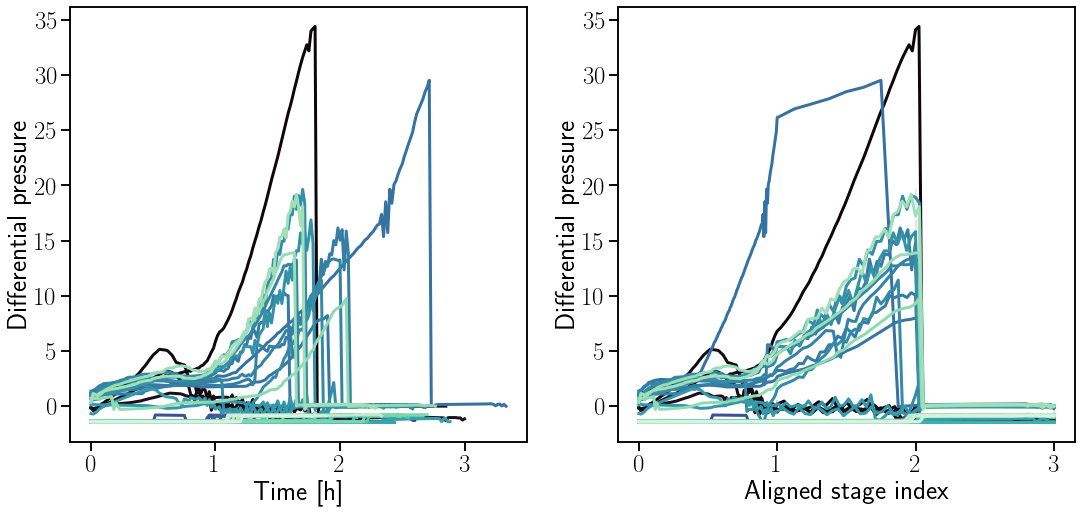

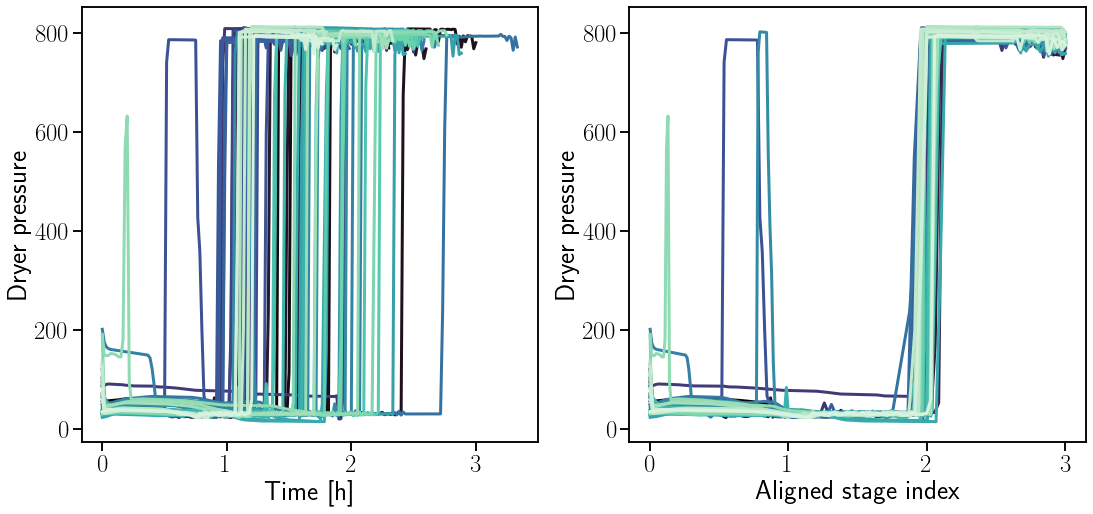

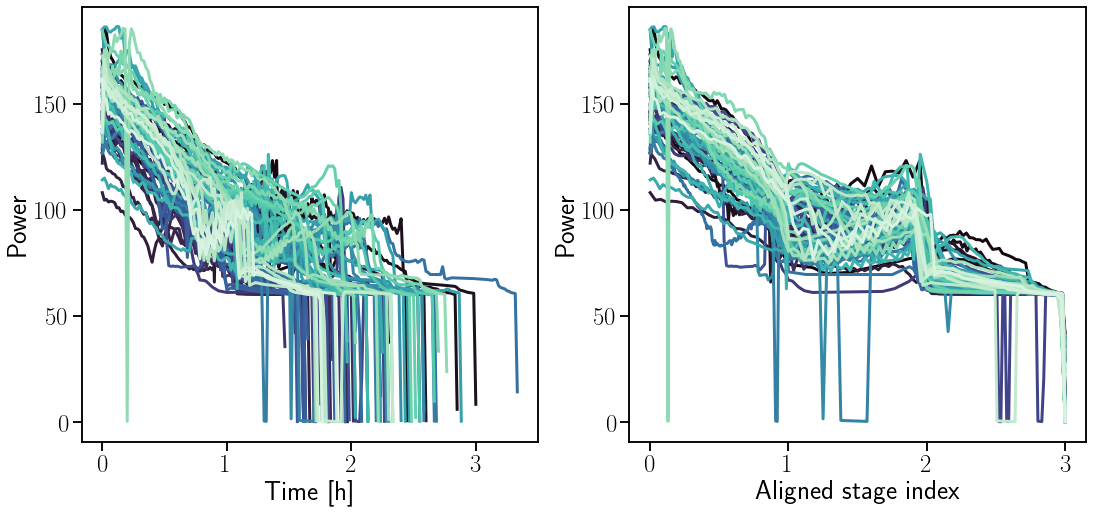

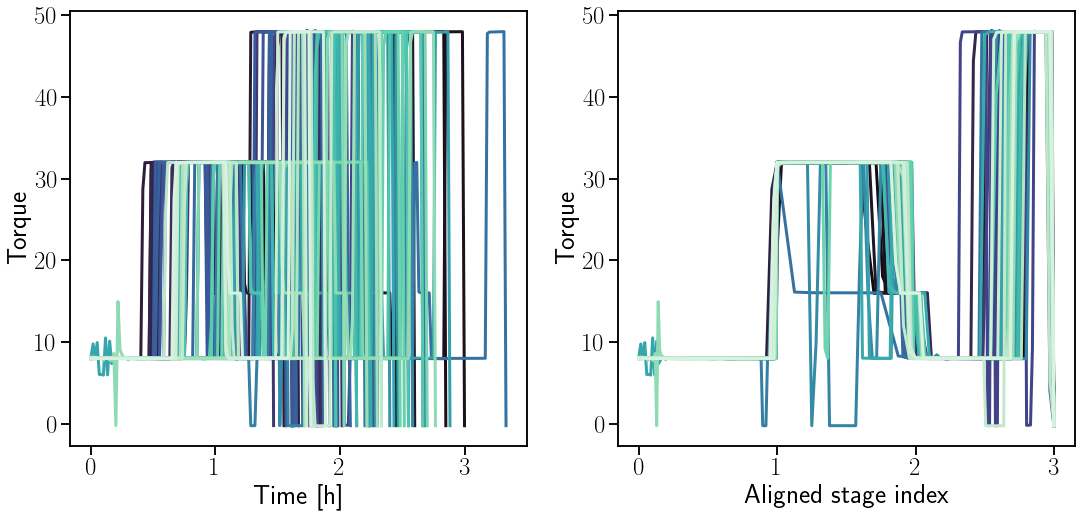

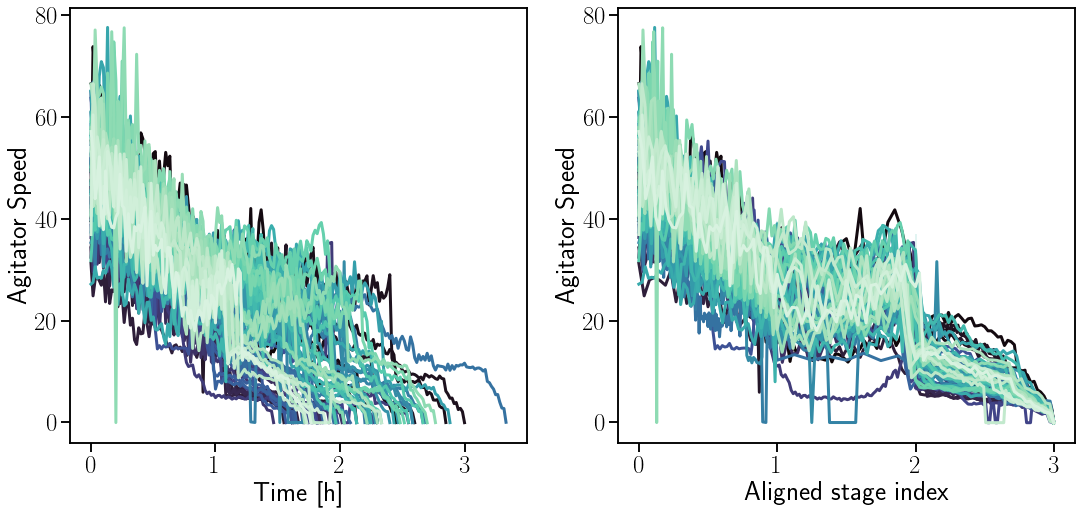

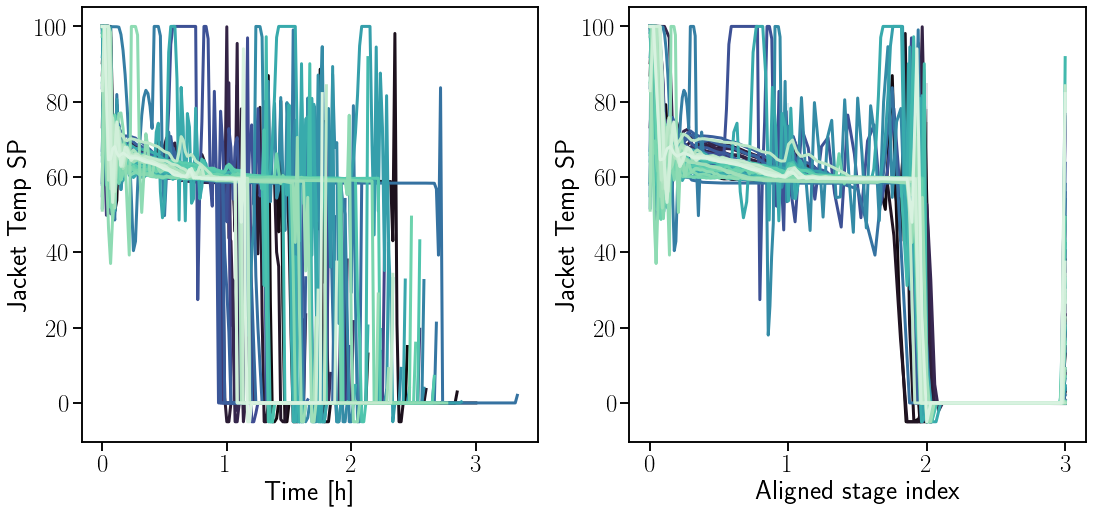

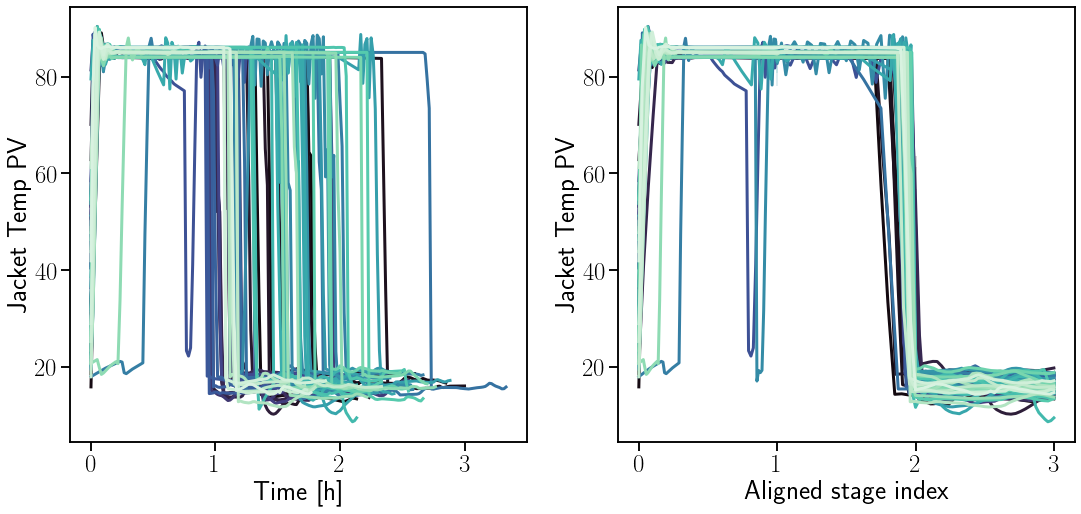

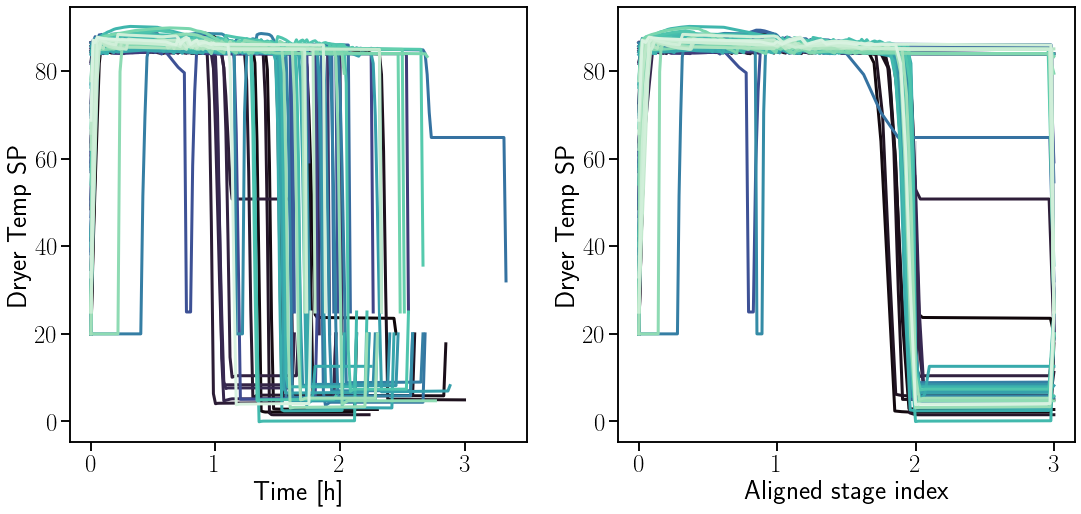

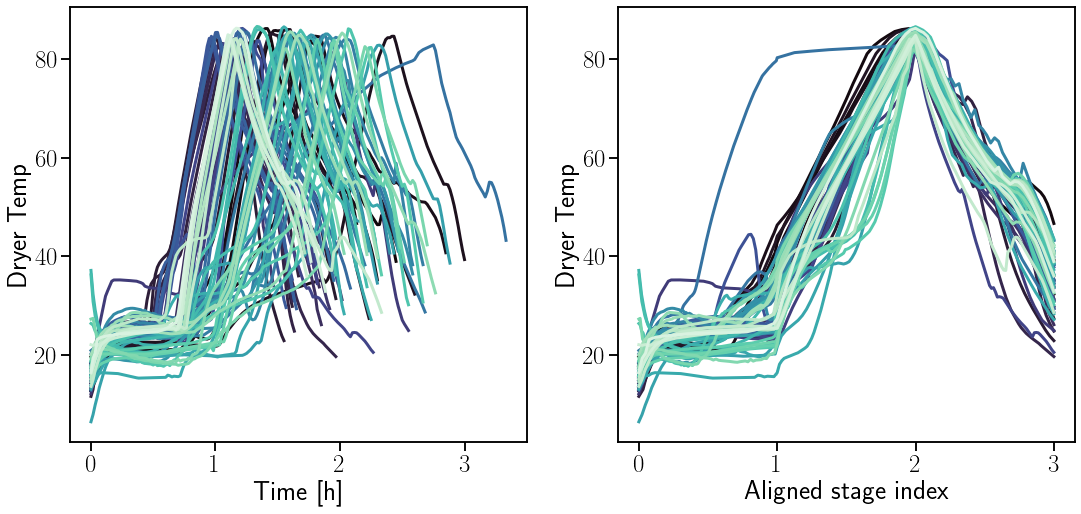

In [114]:
### Batch alingment by automation trigger. ATs are acivated in changes between stages; this alignment thus aligns per stage and linearly interpolates within
sensor_data_df['Phase'].unique()  # There are three stages in this batch process

sensor_data_df['Aligned stage index'] = np.zeros(len(sensor_data_df))

for j in sensor_data_df['Batch number'].unique():
    stage = 0
    for k in sensor_data_df['Phase'].unique():
        stage_time = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == k),'Time [h]']
        sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == k),'Aligned stage index'] = stage + (stage_time-min(stage_time))/(max(stage_time)-min(stage_time))   # linearly interpolate time from stage beginning to end
        stage += 1    # next aligned stage will start 1 unit later

for i in variables[1:]:
    fig_var, ax_var = plt.subplots(1,2, figsize=(18,8))
    a = sns.lineplot(data=sensor_data_df,x='Time [h]',y=i,hue='Batch number',ax=ax_var[0],legend=False,palette='mako')
    b = sns.lineplot(data=sensor_data_df,x='Aligned stage index',y=i,hue='Batch number',ax=ax_var[1],legend=False,palette='mako')

In [132]:
sensor_data_df

Batch number          Phase  Tank level  Differential pressure  \
0         Batch 1  Deagglomerate       0.000                  0.648   
1         Batch 1  Deagglomerate       0.156                  1.028   
2         Batch 1  Deagglomerate       0.981                  1.218   
3         Batch 1  Deagglomerate       1.856                  1.262   
4         Batch 1  Deagglomerate       2.730                  1.332   
...           ...            ...         ...                    ...   
9264     Batch 71       Cooldown      56.971                 -0.857   
9265     Batch 71       Cooldown      56.971                 -0.880   
9266     Batch 71       Cooldown      56.971                 -0.904   
9267     Batch 71       Cooldown      56.971                 -0.917   
9268     Batch 71       Cooldown      56.971                 -0.918   

      Dryer pressure  Power                  Torque                 \
0            119.943                127.302                  8.010   
1             62.902                138.398                  8.010   
2             56.042                141.096                  8.010   
3             56.431                140.870                  8.010   
4             56.820                136.792                  8.010   
...              ...                    ...                    ...   
9264         756.503                 60.490                 48.010   
9265         791.951                 60.335                 48.012   
9266         769.646                 60.225                 48.015   
9267         783.566                 57.595                 48.018   
9268         777.113                  0.304                 -0.223   

      Agitator Speed         Jacket Temp SP         Jacket Temp PV         \
0                    39.515                100.000                 18.697   
1                    40.260                100.000                 38.654   
2                    37.370                100.000                 57.419   
3                    40.803                100.000                 74.791   
4                    35.893                 86.552                 89.337   
...                     ...                    ...                    ...   
9264                  2.958                  0.000                 14.764   
9265                  2.380                  0.000                 14.637   
9266                  2.006                  0.000                 14.523   
9267                  1.801                  0.000                 14.473   
9268                 -0.074                 82.160                 14.775   

      Dryer Temp SP  Dryer Temp  Time [h]  Aligned phase index     Stage  \
0            20.000      19.614  0.000000             0.000000  0.000000   
1            41.161      20.247  0.016667             0.016129  0.002805   
2            57.394      22.018  0.033333             0.032258  0.017638   
3            76.874      21.520  0.050000             0.048387  0.033370   
4            85.059      21.886  0.066667             0.064516  0.049084   
...             ...         ...       ...                  ...       ...   
9264          4.073      48.091  1.700000             2.885714  2.806437   
9265          4.076      46.018  1.716667             2.914286  2.850271   
9266          4.080      43.681  1.733333             2.942857  2.899687   
9267          4.083      41.310  1.750000             2.971429  2.949822   
9268         25.000      38.937  1.766667             3.000000  3.000000   

      Aligned stage index  
0                0.000000  
1                0.016129  
2                0.032258  
3                0.048387  
4                0.064516  
...                   ...  
9264             2.885714  
9265             2.914286  
9266             2.942857  
9267             2.971429  
9268             3.000000  

[9227 rows x 16 columns]

In [178]:
# Here, we'll interpolate to create equal data points per stage for each batch

# Define the number of desired data points per stage
desired_data_points = 30  # Adjust this value as needed. Value should be high enough such that features of the process variable curves are not lost with the linear interpolation

# Create a new DataFrame to store the interpolated data
interpolated_sensor_data = pd.DataFrame()

# Iterate over unique batch numbers
for batch_number in sensor_data_df['Batch number'].unique():
    batch_data = sensor_data_df[sensor_data_df['Batch number'] == batch_number]
    
    # Iterate over unique stages
    stage_begin = 0 
    for stage in batch_data['Phase'].unique():
        stage_data = batch_data[batch_data['Phase'] == stage]

        # Interpolate to achieve the desired number of data points
        interpolated_stage_data = pd.DataFrame()
        interpolated_stage_data['Aligned stage index'] = np.linspace(stage_begin, stage_begin+1, desired_data_points)
        for column in batch_data.columns:
            if column not in ['Batch number', 'Phase', 'Aligned stage index', 'Time [h]']:
                interpolated_stage_data[column] = np.interp(
                    interpolated_stage_data['Aligned stage index'],
                    stage_data['Aligned stage index'],
                    stage_data[column]
                )
        
        # Add 'Batch number', 'Phase', and 'Time [h]' columns
        interpolated_stage_data['Batch number'] = batch_number
        interpolated_stage_data['Phase'] = stage
        interpolated_stage_data['Time [h]'] = np.interp(
            interpolated_stage_data['Aligned stage index'],
            stage_data['Aligned stage index'],
            stage_data['Time [h]']
        )
        
        interpolated_sensor_data = pd.concat([interpolated_data, interpolated_stage_data], ignore_index=True)

        stage_begin += 1        

# Now, 'interpolated_data' contains the interpolated data with an equal number of data points per stage for each batch number

In [179]:
interpolated_sensor_data

Aligned stage index  Tank level  Differential pressure  Dryer pressure  \
0                0.000000    0.000000               0.648000      119.943000   
1                0.052632    2.086000               1.280421       56.533368   
2                0.105263    4.983211               1.561158       57.855368   
3                0.157895    8.581211               1.716368       59.717842   
4                0.210526   12.654105               1.853000       61.320053   
...                   ...         ...                    ...             ...   
4285             2.862069   56.971000              -0.862793      787.026034   
4286             2.896552   56.971000              -0.865724      769.948793   
4287             2.931034   56.971000              -0.894069      778.875655   
4288             2.965517   56.971000              -0.914310      780.686000   
4289             3.000000   56.971000              -0.918000      777.113000   

      Power                  Torque                 Agitator Speed         \
0                127.302000               8.010000              39.515000   
1                139.796842               8.010000              39.510895   
2                134.865053               8.011000              39.577895   
3                131.981158               8.011000              33.880105   
4                127.347895               8.012000              37.761316   
...                     ...                    ...                    ...   
4285              60.709310              48.007517               3.234414   
4286              60.431207              48.010759               2.738759   
4287              60.270517              48.013759               2.160759   
4288              58.139138              48.017379               1.843414   
4289               0.304000              -0.223000              -0.074000   

      Jacket Temp SP         Jacket Temp PV         Dryer Temp SP  Dryer Temp  \
0                100.000000              18.697000      20.000000   19.614000   
1                 96.461053              78.618895      79.027947   21.616316   
2                 67.699842              83.237842      86.661316   23.858684   
3                 61.557158              84.661053      85.967263   25.286947   
4                 63.615368              85.166895      85.738895   25.775737   
...                     ...                    ...            ...         ...   
4285               0.000000              14.921241       4.069690   49.611276   
4286               0.000000              14.715828       4.074138   47.304690   
4287               0.000000              14.570172       4.078345   44.648034   
4288               0.000000              14.483345       4.082379   41.800552   
4289              82.160000              14.775000      25.000000   38.937000   

      Aligned phase index     Stage Batch number          Phase  Time [h]  
0                0.000000  0.000000      Batch 1  Deagglomerate  0.000000  
1                0.052632  0.037505      Batch 1  Deagglomerate  0.054386  
2                0.105263  0.089595      Batch 1  Deagglomerate  0.108772  
3                0.157895  0.154286      Batch 1  Deagglomerate  0.163158  
4                0.210526  0.227514      Batch 1  Deagglomerate  0.217544  
...                   ...       ...          ...            ...       ...  
4285             2.862069  2.774290     Batch 71       Cooldown  1.686207  
4286             2.896552  2.823063     Batch 71       Cooldown  1.706322  
4287             2.931034  2.879239     Batch 71       Cooldown  1.726437  
4288             2.965517  2.939450     Batch 71       Cooldown  1.746552  
4289             3.000000  3.000000     Batch 71       Cooldown  1.766667  

[4290 rows x 16 columns]

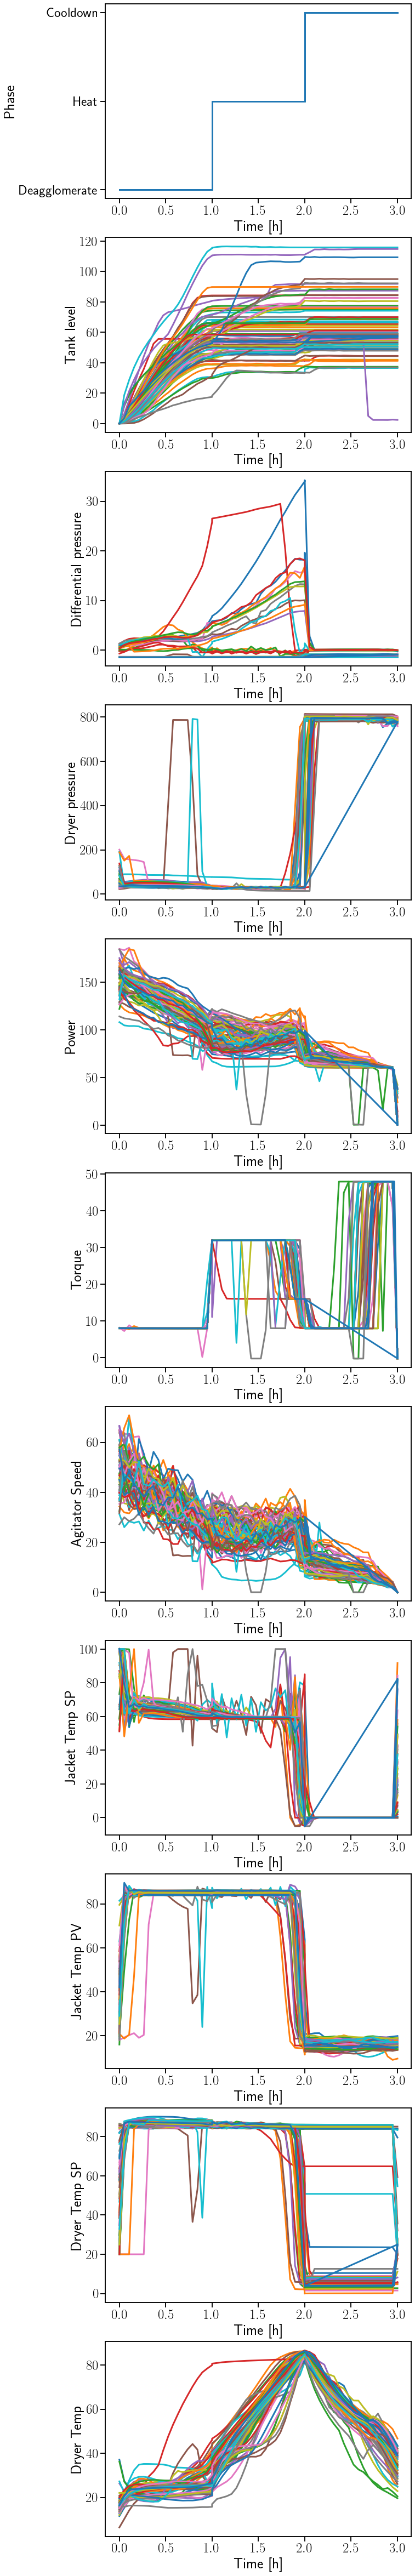

In [180]:
fig, ax = plt.subplots(len(variables),1,figsize=(10,85))
for j in range(len(variables)):
    variable = variables[j]
    ax[j].set_ylabel(variable)
    ax[j].set_xlabel('Time [h]')
    #ax[j].legend(str(sensor_data_df['Batch number'].unique()))
    for i in interpolated_sensor_data['Batch number'].unique(): 
        ax[j].plot(interpolated_sensor_data.loc[(interpolated_sensor_data['Batch number'] == i),'Aligned stage index'],interpolated_sensor_data.loc[(interpolated_sensor_data['Batch number'] == i),variable])


N.B. for the above the number of data points stored for each stage on 'interpolated_sensor_data' is the same. This will give equal weight to all stages on a three-way analysis (e.g. PCA or PLS). If it desired to more heavily weight some stage, a larger number of data points may be interpolated and stored for this stage. This is the approach followed by Salvador Garcia Muñoz on his pyphi library.
Another possibility would be store interpolated data points per stage, relative to the ratio of median duration of the stages, so as to more heavily weight in our posterior analysis the fact that some stages last on average longer than others.

### MULTIPLY EACH STAGE WITH THE MEDIAN DURATION OF THE STAGE!!!
# ??? Notice that the spacing between aligned stage index value is constant within each stage but varies between stages. This ensures that on later chemometric analysis longer stages are weighed heavier.
# If desired, it is also possible to linearly interpolate each stage to its median duration


# If desired, it is also possible to obtain equally spaced variable measurements within each stage for all batch reactors. This would allow further chemometric analysis of the aligned three-way data
# Perform a cubic spline interpolation

In [ ]:
# Here, we'll interpolate to create equal data points per stage for each batch

# Define the number of desired data points per stage
desired_data_points = 30  # Adjust this value as needed. Value should be high enough such that features of the process variable curves are not lost with the linear interpolation

# Create a new DataFrame to store the interpolated data
interpolated_sensor_data = pd.DataFrame()

# Iterate over unique batch numbers
for batch_number in sensor_data_df['Batch number'].unique():
    batch_data = sensor_data_df[sensor_data_df['Batch number'] == batch_number]
    
    # Iterate over unique stages
    stage_begin = 0 
    for stage in batch_data['Phase'].unique():
        stage_data = batch_data[batch_data['Phase'] == stage]

        # Interpolate to achieve the desired number of data points
        interpolated_stage_data = pd.DataFrame()
        interpolated_stage_data['Aligned stage index'] = np.linspace(stage_begin, stage_begin+1, desired_data_points)
        for column in batch_data.columns:
            if column not in ['Batch number', 'Phase', 'Aligned stage index', 'Time [h]']:
                interpolated_stage_data[column] = np.interp(
                    interpolated_stage_data['Aligned stage index'],
                    stage_data['Aligned stage index'],
                    stage_data[column]
                )
        
        # Add 'Batch number', 'Phase', and 'Time [h]' columns
        interpolated_stage_data['Batch number'] = batch_number
        interpolated_stage_data['Phase'] = stage
        interpolated_stage_data['Time [h]'] = np.interp(
            interpolated_stage_data['Aligned stage index'],
            stage_data['Aligned stage index'],
            stage_data['Time [h]']
        )
        
        interpolated_sensor_data = pd.concat([interpolated_data, interpolated_stage_data], ignore_index=True)

        stage_begin += 1        

# Now, 'interpolated_data' contains the interpolated data with an equal number of data points per stage for each batch number

Index(['Phase', 'Tank level', 'Differential pressure', 'Dryer pressure',
       'Power                ', 'Torque               ',
       'Agitator Speed       ', 'Jacket Temp SP       ',
       'Jacket Temp PV       ', 'Dryer Temp SP', 'Dryer Temp'],
      dtype='object')

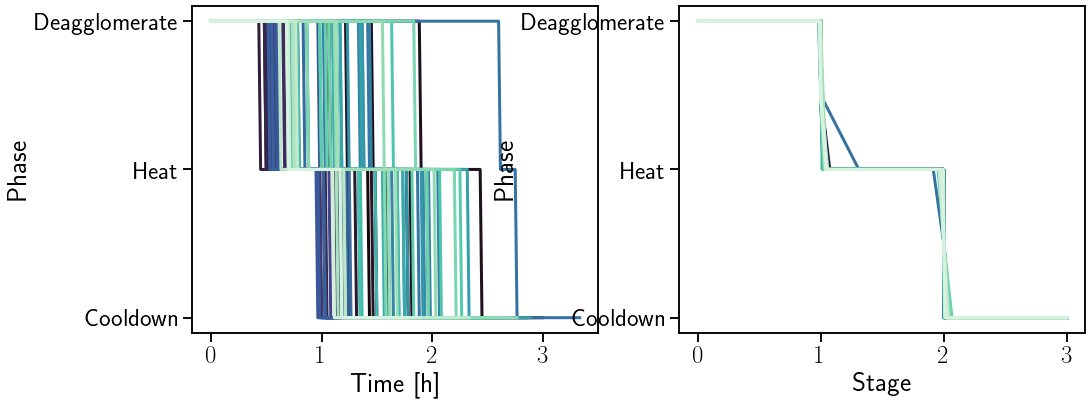

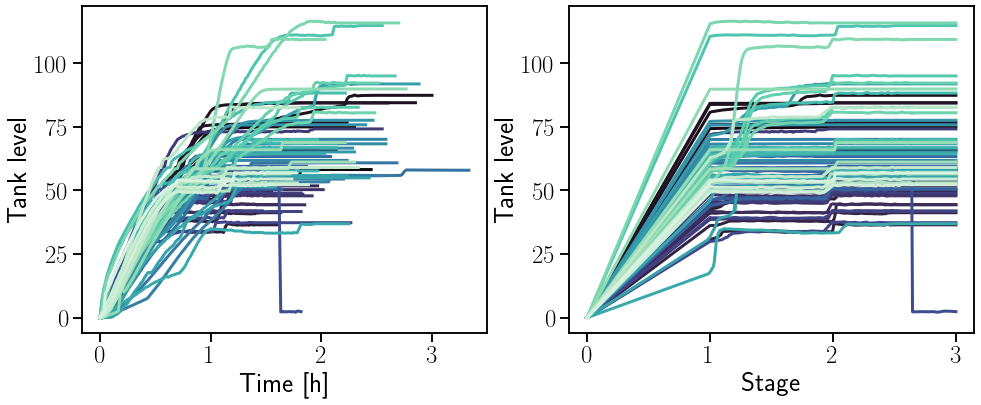

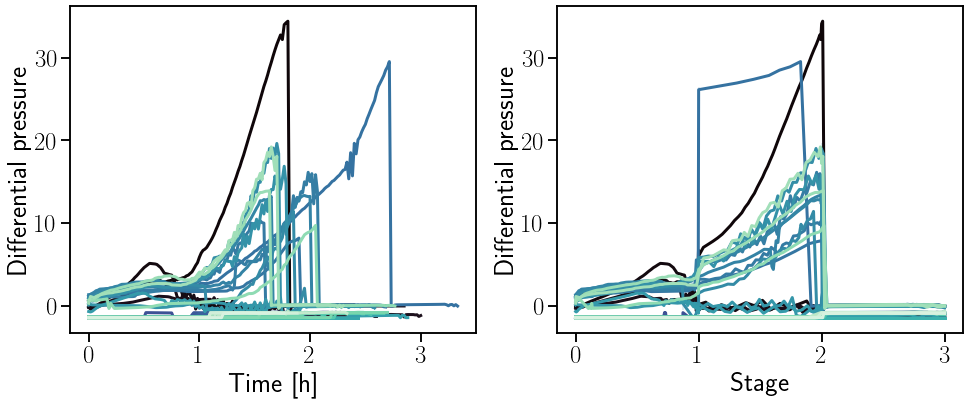

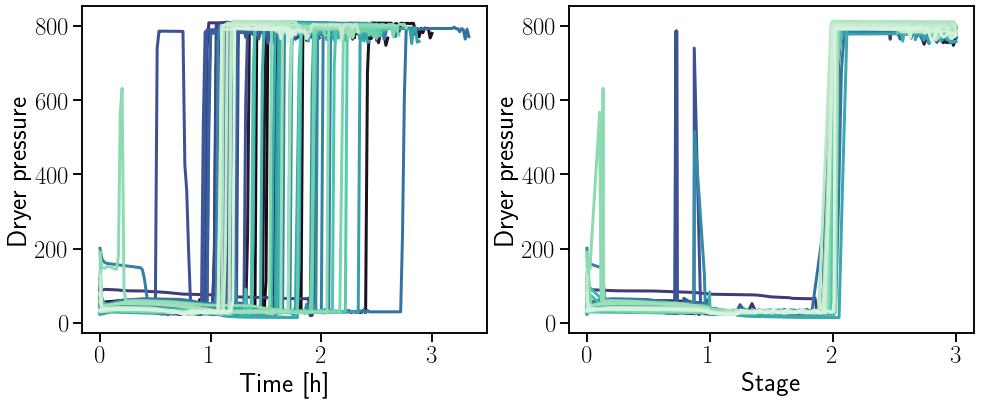

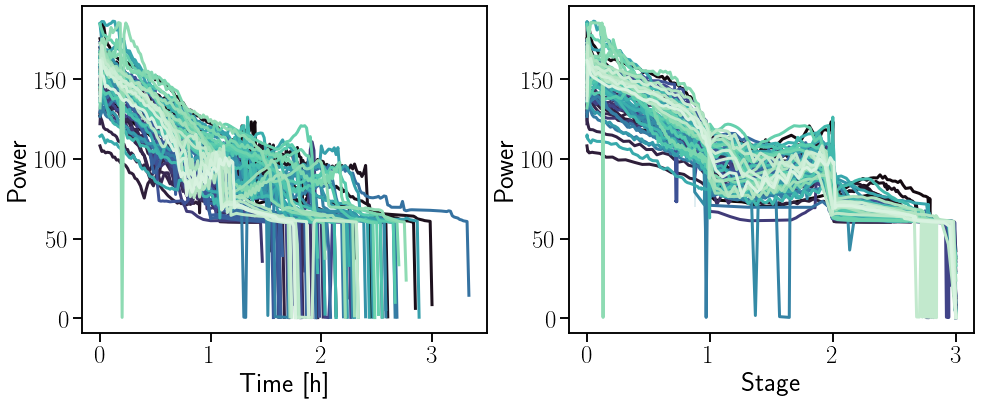

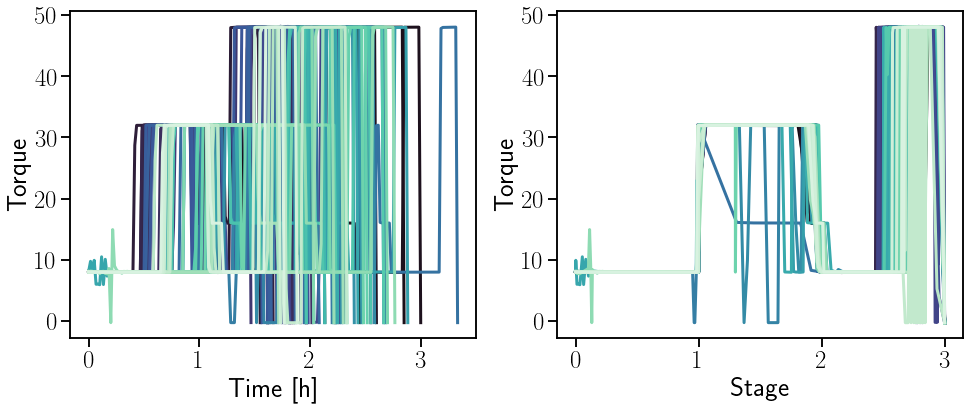

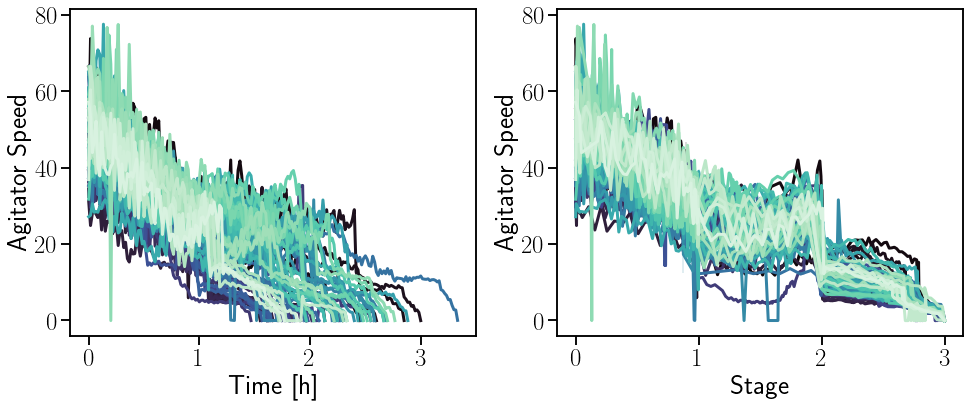

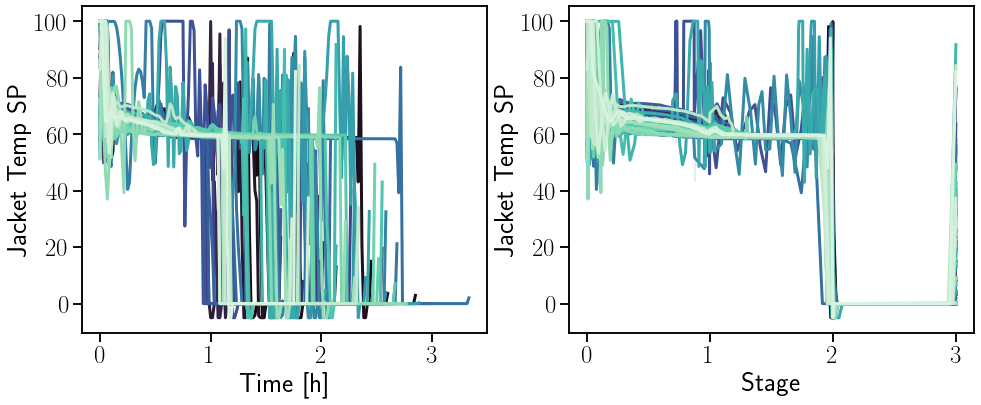

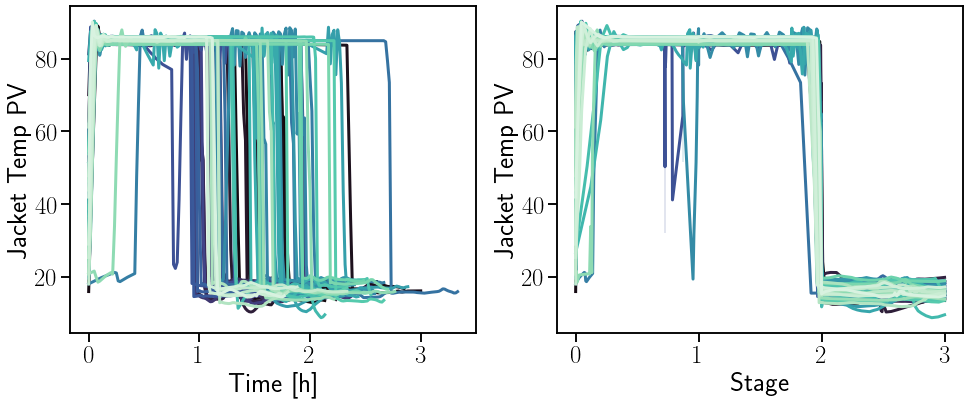

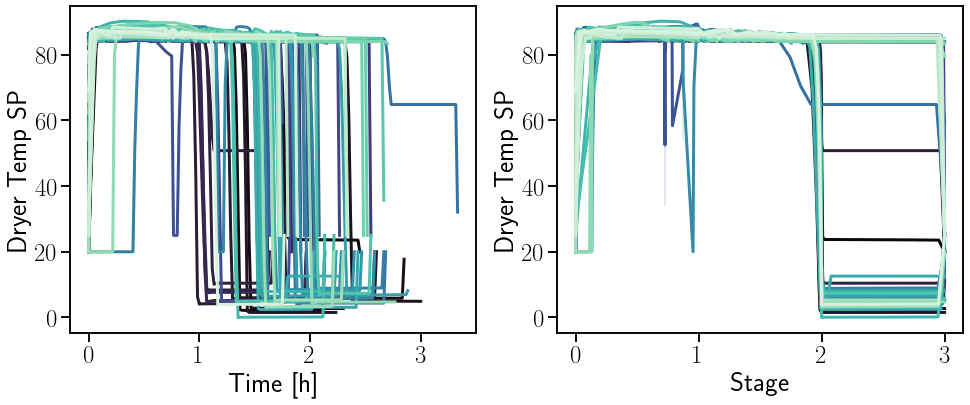

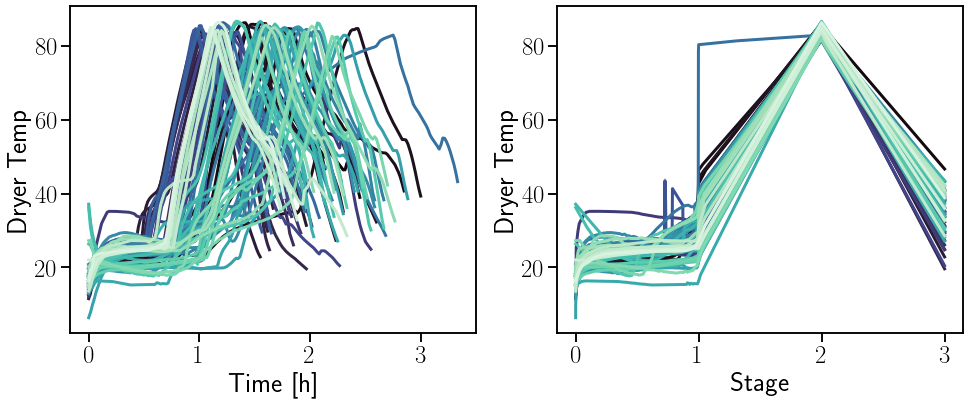

In [26]:
### Indicator variable approach
# The indicator variable per stage needs to be manually selected by an expert

# Three indicator variables (one per stage). Each stage is assumed to account for 33.3% of the progress of the batch. Within this 1/3 of the x axis, plot variables w.r.t. indicator variable
sensor_data_df['Stage'] = np.zeros(len(sensor_data_df))
for j in sensor_data_df['Batch number'].unique():
    deagglomerate = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Deagglomerate'),'Tank level']
    sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Deagglomerate'),'Stage'] = 0 + (deagglomerate-min(deagglomerate))/(max(deagglomerate)-min(deagglomerate))
    heat = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Heat'),'Dryer Temp']
    sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Heat'),'Stage'] = 1 + (heat-min(heat))/(max(heat)-min(heat))
    cooldown = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Cooldown'),'Dryer Temp']
    sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Cooldown'),'Stage'] = 2 + (cooldown-max(cooldown))/(min(cooldown)-max(cooldown)) # susbtract max in the numerator since indicator variable is monotonically DECREASING on this stage

for i in variables:
    fig_var, ax_var = plt.subplots(1,2, figsize=(16,6))
    a = sns.lineplot(data=sensor_data_df,x='Time [h]',y=i,hue='Batch number',ax=ax_var[0],legend=False,palette='mako')
    b = sns.lineplot(data=sensor_data_df,x='Stage',y=i,hue='Batch number',ax=ax_var[1],legend=False,palette='mako')

variables

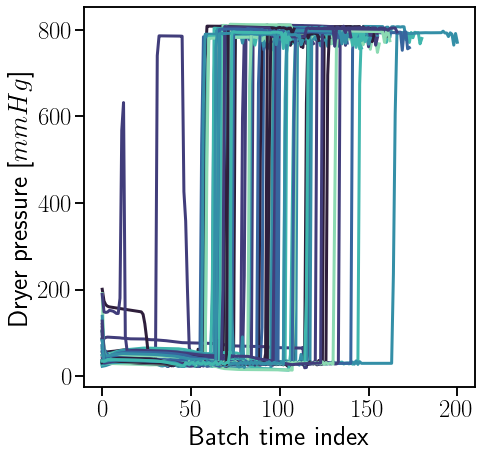

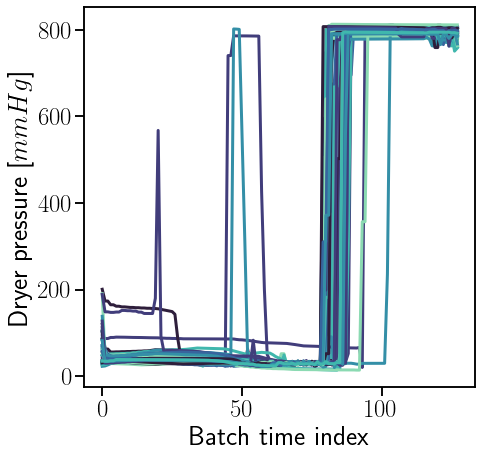

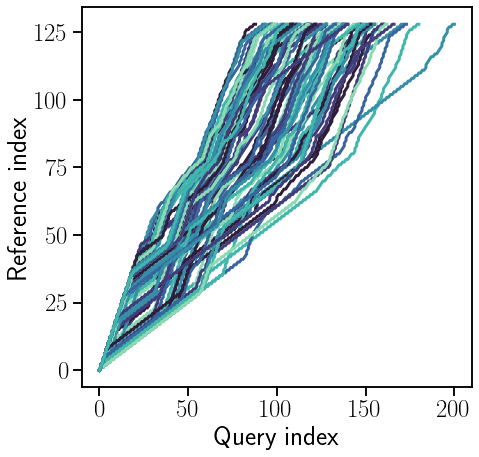

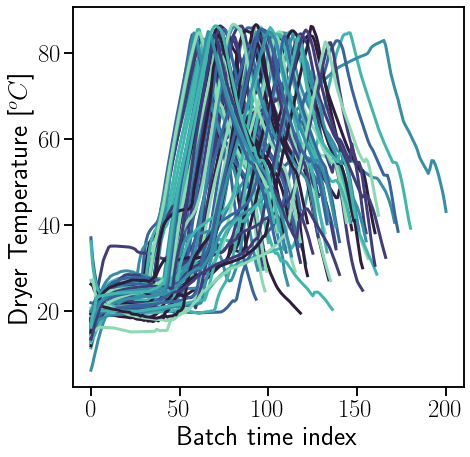

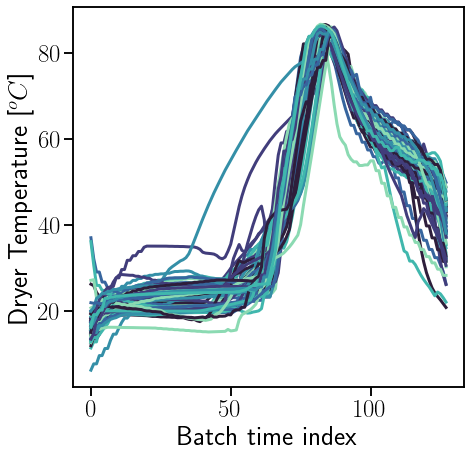

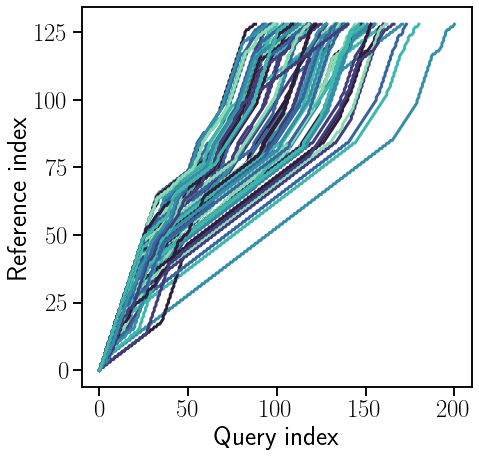

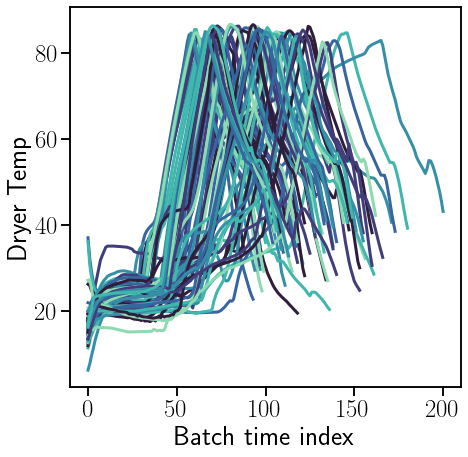

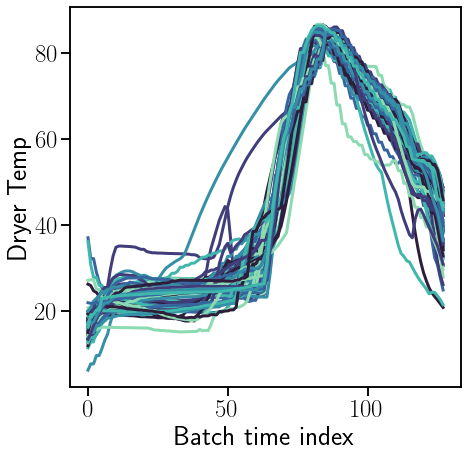

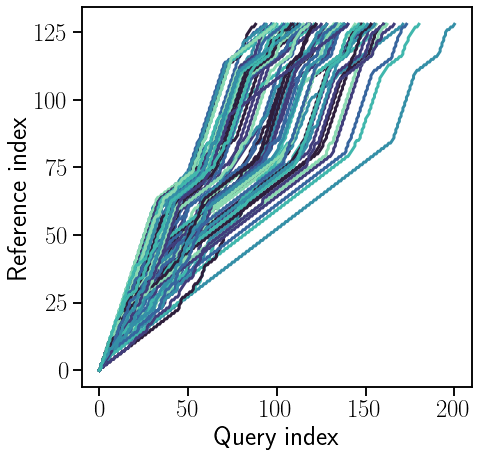

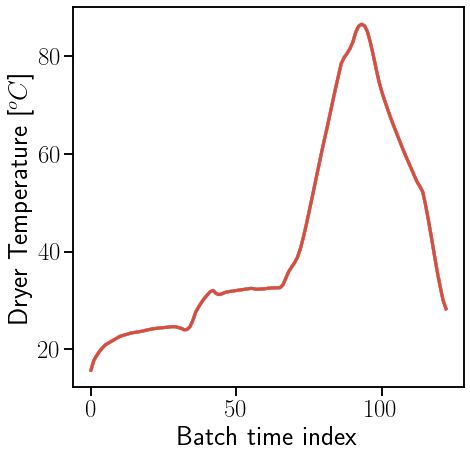

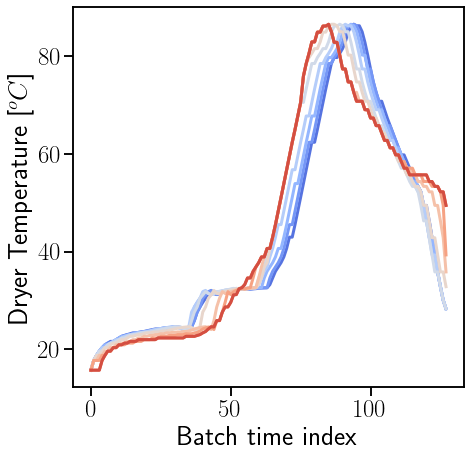

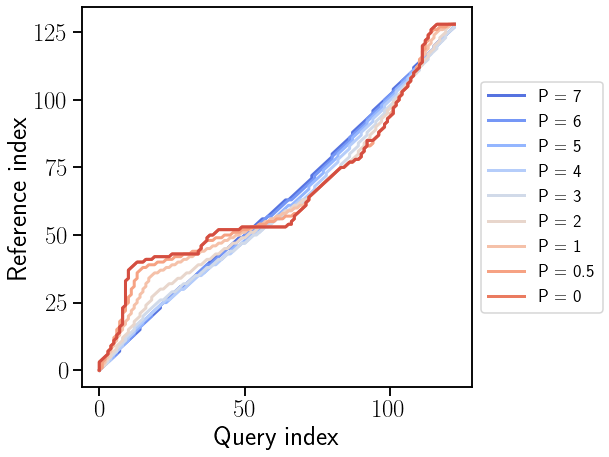

In [5]:
# Change palette for the matplotlib figures as well
sns.set_palette('mako')

### Dynamic Time Warping

# Select batch with the median duration (time) as reference and warp the rest with respect to this one
median_runtime = np.median(batch_durations)   # median runtime for all batch runs
median_duration_run = min(batch_durations, key=lambda x:abs(x-median_runtime))  # duration of the batch closest to the median time (consider that with even number the median is calcualted as (n/2+(n/2+1))/2, so this number will be different than if the median_runtime is odd, i.e., (batch_durations % 2) == 0
median_index = batch_durations.index(median_duration_run) + 1  # determine the index of the run with the median duration. Add 1 to account for the 0-indexing of Python (the first batch number will be 1)

from new_step_patterns import *

# Change the local constraint to symmetricP0, symmetricP05, symmetricP1, symmetricP2, ..., symmetricP10 and then run the function to obtain the graphs
def DTW_alignment_plot():
    warped_batches_cDTW = []
    fig1, axes1 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes1.set_xlabel('Batch time index'), axes1.set_ylabel('Dryer pressure [$mmHg$]')

    fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes2.set_xlabel('Batch time index'), axes2.set_ylabel('Dryer pressure [$mmHg$]')

    fig_2way, axes_2way = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes_2way.set_xlabel('Query index')
    axes_2way.set_ylabel('Reference index')

    for i in sensor_data_df['Batch number'].unique():   # iterate over the batch runs
        try:
            # Multivariate classical DTW
            query_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == i, 'Dryer Temp'].to_numpy()
            reference_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), 'Dryer Temp'].to_numpy()   # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW
            alignment_cDTW = dtw(query_cDTW,reference_cDTW,keep_internals=True,open_end=False,step_pattern=symmetricP1,window_type=sakoeChibaWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
            wq_cDTW = warp(alignment_cDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.

            # Plot the results
            axes1.plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == i])),sensor_data_df.loc[sensor_data_df['Batch number'] == i,'Dryer pressure'])   # unwarped query
            axes2.plot(np.arange(len(wq_cDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == i,'Dryer pressure'].reset_index(drop=True)[wq_cDTW])  # warped query
            axes_2way.plot(alignment_cDTW.index1,alignment_cDTW.index2)
        except:
            pass

    # Plot the reference in red
    #axes1.plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index)])),sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index),'Dryer Temp'],color='red',linewidth=4)   # unwarped query
    #axes2.plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index)])),sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index),'Dryer Temp'],color='red',linewidth=4)  # warped query
    #length = len(sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index)])
    #axes_2way.plot([0,length],[0,length],color='red',linewidth=4)

DTW_alignment_plot()




# Derivative DTW
def DDTW_alignment_plot():
    warped_batches_cDTW = []
    fig1, axes1 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes1.set_xlabel('Batch time index'), axes1.set_ylabel('Dryer Temperature [$^{o}C$]')

    fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes2.set_xlabel('Batch time index'), axes2.set_ylabel('Dryer Temperature [$^{o}C$]')

    fig_2way, axes_2way = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes_2way.set_xlabel('Query index')
    axes_2way.set_ylabel('Reference index')

    for i in sensor_data_df['Batch number'].unique():   # iterate over the batch runs
        try:
            delta_t = sensor_data_df.loc[sensor_data_df['Batch number']=='Batch '+str(median_index),'Time [h]'].iloc[1-0] # calculate the ∆t for the finite forward derivatives. Also consider that ∆t is the same as samples were measured every 120 s

            # Multivariate derivative DTW
            query = sensor_data_df.loc[sensor_data_df['Batch number'] == i, variables].ewm(span=10).mean()
            query_diff = np.diff(query)/delta_t  # consider that the time grid is equsipaced at 120 s, so ∆t will remain constant
            reference = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), variables].ewm(span=10).mean()   # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW
            #reference = sim_data_df.loc[(sim_data_df['batch number'] == median_index) & (sim_data_df['stage']==3), warping_variables[j-1]].ewm(span=8).mean()   # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW
            reference_diff = np.diff(reference)/delta_t
            alignment_dDTW = dtw(query_diff,reference_diff,keep_internals=True,open_end=False,step_pattern=symmetricP1,window_type=slantedBandWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
            wq_dDTW = warp(alignment_dDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.

            # Plot the results
            axes1.plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == i])),sensor_data_df.loc[sensor_data_df['Batch number'] == i,'Dryer Temp'])   # unwarped query
            axes2.plot(np.arange(len(wq_dDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == i,'Dryer Temp'].reset_index(drop=True)[wq_dDTW])  # warped query
            axes_2way.plot(alignment_dDTW.index1,alignment_dDTW.index2)
        except:
            pass

DDTW_alignment_plot()



# Robust Derivative DTW
def RDDTW_alignment_plot():
    warped_batches_cDTW = []
    fig1, axes1 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes1.set_xlabel('Batch time index'), axes1.set_ylabel('Dryer Temp')

    fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes2.set_xlabel('Batch time index'), axes2.set_ylabel('Dryer Temp')

    fig_2way, axes_2way = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes_2way.set_xlabel('Query index')
    axes_2way.set_ylabel('Reference index')

    for i in sensor_data_df['Batch number'].unique():   # iterate over the batch runs
        try:
            delta_t = sensor_data_df.loc[sensor_data_df['Batch number']=='Batch '+str(median_index),'Time [h]'].iloc[1-0] # calculate the ∆t for the finite forward derivatives. Also consider that ∆t is the same as samples were measured every 120 s

            # Multivariate robust derivative DTW
            query = sensor_data_df.loc[sensor_data_df['Batch number'] == i, variables].to_numpy()
            filtered_query = savgol_filter(query,window_length=7,polyorder=5)
            query_diff = np.diff(filtered_query)/delta_t
            reference = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), variables].to_numpy()  # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW
            filtered_reference = savgol_filter(reference,window_length=7,polyorder=5)
            reference_diff = np.diff(filtered_reference)/delta_t
            alignment_rdDTW = dtw(query_diff,reference_diff,keep_internals=True,open_end=False,step_pattern=symmetricP1,window_type=slantedBandWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
            wq_rdDTW = warp(alignment_rdDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.

            # Plot the results
            axes1.plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == i])),sensor_data_df.loc[sensor_data_df['Batch number'] == i,'Dryer Temp'])   # unwarped query
            axes2.plot(np.arange(len(wq_rdDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == i,'Dryer Temp'].reset_index(drop=True)[wq_rdDTW])  # warped query
            axes_2way.plot(alignment_rdDTW.index1,alignment_rdDTW.index2)
        except:
            pass

RDDTW_alignment_plot()





sns.set_palette("coolwarm",n_colors=10)


def effects_of_increasing_P():
    warped_batches_cDTW = []
    fig1, axes1 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes1.set_xlabel('Batch time index'), axes1.set_ylabel('Dryer Temperature [$^{o}C$]')

    fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes2.set_xlabel('Batch time index'), axes2.set_ylabel('Dryer Temperature [$^{o}C$]')

    fig_2way, axes_2way = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
    axes_2way.set_xlabel('Query index')
    axes_2way.set_ylabel('Reference index')

    # Multivariate classical DTW
    query_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch 49', 'Dryer Temp'].to_numpy()
    reference_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), 'Dryer Temp'].to_numpy()   # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW

    for local_constraint_P in [symmetricP7,symmetricP6,symmetricP5,symmetricP4,symmetricP3,symmetricP2,symmetricP1,symmetricP05,symmetricP0,symmetricP0]:   # iterate over the batch runs
        alignment_cDTW = dtw(query_cDTW,reference_cDTW,keep_internals=True,open_end=False,step_pattern=local_constraint_P,window_type=sakoeChibaWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
        wq_cDTW = warp(alignment_cDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.

        # Plot the results
        axes1.plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch 49'])),sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch 49','Dryer Temp'])   # unwarped query
        axes2.plot(np.arange(len(wq_cDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch 49','Dryer Temp'].reset_index(drop=True)[wq_cDTW])  # warped query

        box = axes_2way.get_position()
        axes_2way.set_position([box.x0, box.y0, box.width, box.height])

        # Put a legend to the right of the current axis
        axes_2way.legend(['P = 7','P = 6','P = 5','P = 4','P = 3','P = 2','P = 1','P = 0.5','P = 0'],loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 18})

        axes_2way.plot(alignment_cDTW.index1,alignment_cDTW.index2)

effects_of_increasing_P()

# Best batch: 13